In [14]:
import sys
import pandas as pd
from database_connection import database_query
from sklearn.cluster import KMeans

sys.path.insert(0, './Moduulit')
pd.options.mode.chained_assignment = None

# Importtaus tässä muodossa
from outliers import find_outliers, draw_histogram
from clean_dataframe import clean_dataframe
from write_df_to_database import write_df_to_mariadb
from xy_diskretisointi import xy_to_grid
from isolation_forest import *
from reittien_erottelu import *
from sisään_uloskäynnit import *
# tai from ... import *

# Database query

In [2]:
df = database_query("SELECT * FROM SensorData limit 10000")
df.head(5)

,node_id,timestamp,x,y,z,q
0,b'-2393099149039893833',b'2020-06-24 12:20:08.533016+00:00',2762,-257,100,0
1,b'-2393099149039893833',b'2020-06-24 12:20:08.620015+00:00',2870,-344,100,0
2,b'-2393099149039893833',b'2020-06-24 12:20:09.622827+00:00',2916,-344,100,0
3,b'-2393099149039893833',b'2020-06-24 12:20:09.622846+00:00',2894,-254,100,0
4,b'-2393099149039893833',b'2020-06-24 12:20:10.116102+00:00',2888,-188,100,0


# Find outliers using z_score

Number of missing variables in table
 node_id      0
timestamp    0
x            0
y            0
z            0
q            0
dtype: int64
------------------------------
Unique values in columns

uniques in x 2549
uniques in y 2778
uniques in z 1
uniques in q 1
------------------------------
Checking z and q columns

uniques in z [100]
uniques in q [0]
------------------------------
Number of nodes: 1
------------------------------
Outliers

Data with outliers:  10000
Ouliers removed:     152
Data after:  9848


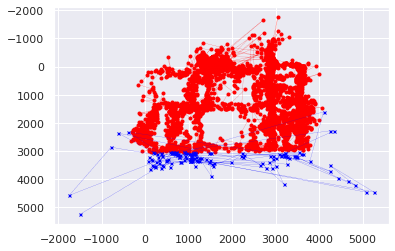

In [3]:
df1 = find_outliers(df)

# Cleaning Node_id, timestamp, q, z columns

In [4]:
df1 = clean_dataframe(df1)
df1

,index,node_id,timestamp,x,y
0,0,1,2020-06-24 15:20:08.533,2762,-257
1,1,1,2020-06-24 15:20:08.620,2870,-344
2,2,1,2020-06-24 15:20:09.623,2916,-344
3,3,1,2020-06-24 15:20:09.623,2894,-254
4,4,1,2020-06-24 15:20:10.116,2888,-188
...,...,...,...,...,...
9623,9995,1,2020-06-29 13:19:16.418,1301,-120
9624,9996,1,2020-06-29 13:19:25.418,1301,-119
9625,9997,1,2020-06-29 13:19:35.418,1305,-112
9626,9998,1,2020-06-29 13:19:45.418,1305,-112


# Poistetaan vialliset / puutteelliset nodet

In [5]:
df1 = df1[df1.node_id != 13]
df1 = df1[df1.node_id != 14]
df1 = df1[df1.node_id != 18]
df1 = df1[df1.node_id != 32]

# Adding xy_grid values to dataframe (50x50)

In [6]:
grid_size = 40
df1 = xy_to_grid(df1, df1.x, df1.y, grid_size)
df1.head()

,index,node_id,timestamp,x,y,x_grid,y_grid,grid_id
0,0,1,2020-06-24 15:20:08.533,2762,-257,27,12,507
1,1,1,2020-06-24 15:20:08.620,2870,-344,28,11,468
2,2,1,2020-06-24 15:20:09.623,2916,-344,28,11,468
3,3,1,2020-06-24 15:20:09.623,2894,-254,28,12,508
4,4,1,2020-06-24 15:20:10.116,2888,-188,28,12,508


# Find and draw exits

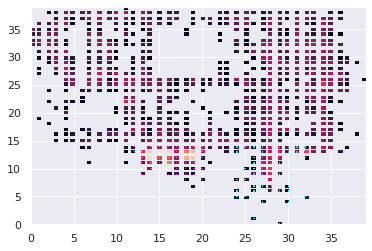

In [7]:
in_x, in_y = sisään(df1)
out_x, out_y = ulos(df1)

draw_exits(df1, in_x, in_y, out_x, out_y)

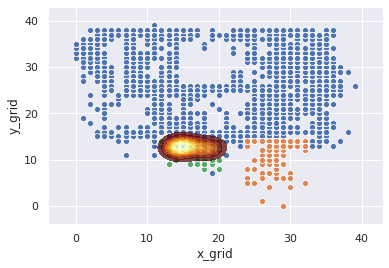

In [8]:
# Muokataan sisäänkäynnin ja kassojen sijainnit ID-muotoon.
in_ID = xy_to_ID(in_x,in_y, grid_size)
out_ID = xy_to_ID(out_x,out_y, grid_size)

# # Voidaan tarkistaa sijaintien oikeellisuus
sns.scatterplot(x="x_grid", y="y_grid", data = df1)
sns.scatterplot(x=in_x, y=in_y)
sns.scatterplot(x=out_x, y=out_y)
hmax= sns.kdeplot(df1.x_grid, df1.y_grid, cmap="afmhot", shade=True, alpha = 0.7)
hmax.collections[3].set_alpha(0)
plt.show()


### Erotetaan kauppareissut toisistaan

In [9]:
# Haetaan uniikit id:t
u_in_ID = in_ID.unique()
u_out_ID = out_ID.unique()

reitit = erottele_reitit(df1, u_in_ID, u_out_ID)

reitit = poista_lyhyet_reitit(reitit, 50)
df_reitit = reitit_dataframeksi(reitit)


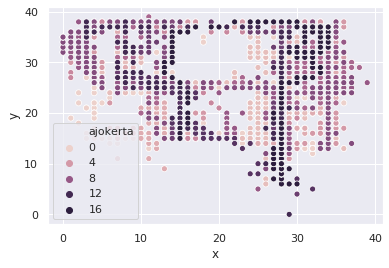

In [10]:
# Plotataan kaikki erotellut kauppareissut yhdessä
plot_all_routes(df_reitit, grid_size)

In [11]:
def table_to_XY(df):
    X = df.drop(['index', 'node_id', 'grid_id', 'timestamp', 'x_grid', 'y_grid'], axis=1)
    Y = df['grid_id']
    return X, Y

In [12]:
X, Y = table_to_XY(df1)

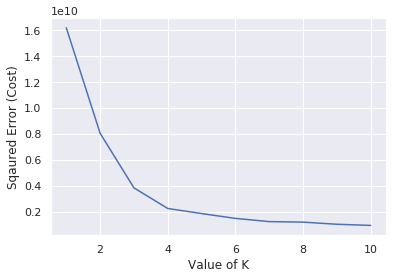

In [44]:
from sklearn.cluster import KMeans

def ideal_k():
    ideal_k = []
    for i in range(1,11):
        est_kmeans = KMeans(n_clusters=i, init='random')
        est_kmeans.fit(X)

        #print(est_kmeans.score(X))

        ideal_k.append([i,est_kmeans.inertia_])

    ideal_k = np.array(ideal_k)

    plt.plot(ideal_k[:,0],ideal_k[:,1])
    plt.xlabel("Value of K") 
    plt.ylabel("Sqaured Error (Cost)") 
    plt.show()

ideal_k()

### Ideaali K:n arvo on 4, mutta se ei ole itseasiassa se mitä halutaan...

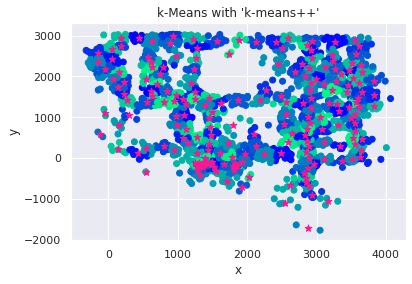

In [15]:
plt.set_cmap('winter')

# Opetetaan malli ja tehdään eenustus
est_kmeans = KMeans(n_clusters=200, init='k-means++')
est_kmeans.fit(X)
pred_kmeans = est_kmeans.predict(X)

# Clusterien keskipisteet
centers = est_kmeans.cluster_centers_

def draw_kmeans():
    plt.scatter(X['x'], X['y'], c=pred_kmeans)

    plt.scatter(centers[:, 0], centers[:, 1], c='deeppink', marker='*', s=50)
    plt.title("k-Means with 'k-means++'")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    
draw_kmeans()

### Tehdään clusterien keskipisteistä gridi

In [16]:
aisle = pd.DataFrame(centers, columns=['x', 'y'])
# Tehdään gridi
aisle = xy_to_grid(aisle, aisle.x, aisle.y, grid_size)
# Pudotetaan x ja y
aisle = aisle.drop(['x', 'y'], axis=1)
aisle.head()

,x_grid,y_grid,grid_id
0,16,13,536
1,30,30,1230
2,7,27,1087
3,30,13,550
4,33,23,953


### Pyöritellään taulukoita oikeaan muotoon

In [17]:
reitit_dropped = df_reitit.drop(['ajokerta', 'timestamp', 'node_id'], axis=1)
reitit_dropped.rename(columns = {'ID':'grid_id', 'x':'x_grid', 'y':'y_grid'}, inplace = True)
reitit_dropped

,grid_id,x_grid,y_grid
0,468,28,11
1,468,28,11
2,508,28,12
3,508,28,12
4,508,28,12
...,...,...,...
3918,695,15,17
3919,655,15,16
3920,615,15,15
3921,655,15,16


### Verrataan keskipisteitä reitteihin: 
Yhditetään keskipiste taulu reitti tauluun ja poistetaan dublikaatit. Näin löytyy reittien keskipisteet

In [211]:
df_yhdistetty = reitit_dropped.drop_duplicates().merge(aisle.drop_duplicates(), on=aisle.columns.to_list(), 
                                                  how='left', indicator=True)
print(df_yhdistetty['_merge'].unique())
#df2.loc[df2._merge=='left_only',df2.columns!='_merge']
df_yhdistetty = df_yhdistetty.loc[df_yhdistetty['_merge'] == 'both']
df2 = df_yhdistetty.drop(columns=['_merge'])
df2

[left_only, both]
Categories (2, object): [left_only, both]


,grid_id,x_grid,y_grid
4,589,29,14
5,551,31,13
8,674,34,16
11,755,35,18
15,953,33,23
...,...,...,...
640,270,30,6
641,389,29,9
647,1070,30,26
648,1433,33,35


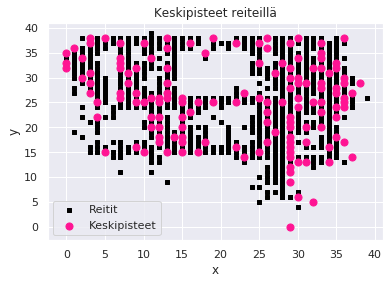

In [263]:
plt.scatter(reitit_dropped['x_grid'], reitit_dropped['y_grid'], c='black', marker='s', s=10, label="Reitit")
plt.scatter(df2['x_grid'], df2['y_grid'], c='deeppink', marker='o', s=50, label="Keskipisteet")
plt.title("Keskipisteet reiteillä")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [264]:
#table0 = np.zeros((20,20), dtype=np.int16)
table1 = np.ones((40,40), dtype=np.int16)

In [201]:
#table1[0] = [0] * 20
#table1[0,:] = [0]
#table1[:,0] = [2]
#table1[:,0] = [0] * 20
print(table1[0,0])
print(table1[0,1])
table1

1
1


array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int16)

In [182]:
df2['x_grid']

449     0
491     0
45      0
565     1
568     2
       ..
588    36
430    36
586    37
556    37
526    38
Name: x_grid, Length: 142, dtype: int64

In [212]:
df2['x_grid'].iloc[0]
#df2.sort_values(by=['x_grid'])
df2.sort_values(['x_grid', 'y_grid'], axis = 0, ascending = [True, True], inplace = True)
df2 = df2.drop(columns=['grid_id'])
df2

,x_grid,y_grid
449,0,32
491,0,33
45,0,35
565,1,36
568,2,30
...,...,...
588,36,30
430,36,38
586,37,14
556,37,27


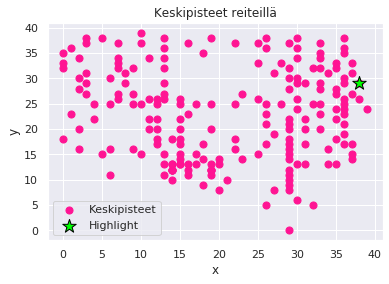

In [270]:
plt.scatter(aisle['x_grid'], aisle['y_grid'], c='deeppink', marker='o', s=50, label="Keskipisteet")
plt.scatter(df2['x_grid'].iloc[-1], df2['y_grid'].iloc[-1], c='lime', marker='*', edgecolors="black", s=200, label="Highlight")
plt.title("Keskipisteet reiteillä")
plt.xlabel('x')
plt.ylabel('y')
#plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [ ]:
centers[:, 0], centers[:, 1]

In [269]:
#df2['x_grid'].iloc[0]
#df2['y_grid'].iloc[0]
'''for i, j in zip(df2['x_grid'], df2['y_grid']):
    table1[j][i] = 0'''
for i, j in zip(aisle['x_grid'], aisle['y_grid']):
    table1[j][i] = 0
#table1[df2['x_grid'].iloc[0]][df2['y_grid'].iloc[0]] = 0
#np.set_printoptions(threshold=sys.maxsize)

#pd.set_option('display.max_colwidth', None)

print('\n'.join(' '.join(str(cell) for cell in row) for row in np.flipud(table1)))
print(np.flipud(table1))

1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1
1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1
1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1
0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1
1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1
0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1
0 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1
1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1
1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1
1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 0 1 0 1
1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1
1 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 